## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
# Define camera class, which keeps all camera information

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

class Camera():
    def __repr__(self):
        return 'Camera()'
    
    def __init__(self):
        # name of the file, where pickle with calibration results are stored
        self.calibration_pickle_file_name = "callibration_pickle.p"
        # path to images used to calibrate camera
        self.calibration_images = 'camera_cal/calibration*.jpg'
        
        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
        
        # boolean indicator if camera is calibrated
        self.is_calibrated = False
        
        # distortion pickle
        self.dist_pickle = {}
        
        # calibration params
        self.mtx = None
        self.dist = None
    
    def calibrate(self, chess_x: int, chess_y: int, show_result: bool = False):
        '''
        `chess_x` pattern size in X direction
        `chess_y` pattern size in Y direction
        '''
        %matplotlib qt
        
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((chess_y*chess_x,3), np.float32)
        objp[:,:2] = np.mgrid[0:chess_x,0:chess_y].T.reshape(-1,2)
        
        # Make a list of calibration images
        images = glob.glob(self.calibration_images)
        first_image = None
        
        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (chess_x,chess_y),None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (chess_x,chess_y), corners, ret)
                if (first_image is None):
                    first_image = np.copy(img)
                # cv2.imshow('img',img)
                cv2.waitKey(500)

        cv2.destroyAllWindows()
        
        img_size = (first_image.shape[1], first_image.shape[0])
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
        
        %matplotlib inline
        
        if ret:
            self.is_calibrated = True
            # Save the camera calibration result for later use
            self.dist_pickle["mtx"] = mtx
            self.dist_pickle["dist"] = dist
            self.mtx = mtx
            self.dist = dist
            pickle.dump( self.dist_pickle, open( self.calibration_pickle_file_name, "wb" ) )
        
            if show_result:
                undistorted = self.undistort(first_image)
                # Visualize undistortion
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
                ax1.imshow(first_image)
                ax1.set_title('Original Image', fontsize=30)
                ax2.imshow(undistorted)
                ax2.set_title('Undistorted Image', fontsize=30)
    
    def undistort(self, image: np.ndarray):
        '''
        `image` to be undistorted
        '''
        if not self.is_calibrated:
            return None
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)

## Compute the camera calibration using chessboard images and store calibration results

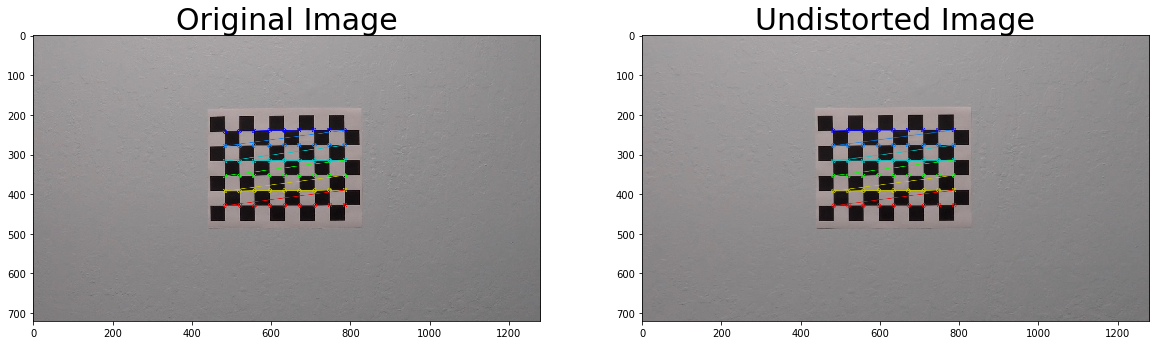

In [2]:
# create camera object
camera = Camera()

# calibrate camera and show result
camera.calibrate(9, 6, True)

# Define Lane class keeping pipeline

In [35]:
import numpy as np
import cv2

class Graph():
    
    @staticmethod
    def to_grayscale(image: np.ndarray):
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    @staticmethod
    def to_3channel_binary(image: np.ndarray):
        color_binary = np.dstack(( image, image, image)) * 255
        return color_binary
    
    @staticmethod
    def histogramGray(image: np.ndarray):
        '''
        `image` grascaled image
        
        Returns histogram of this image.
        '''
        # Grab only the bottom half of the image
        # Lane lines are likely to be mostly vertical nearest to the car
        sizey, sizex = image.shape
        bottom_half = image[sizey//2:,:]

        # Sum across image pixels vertically - make sure to set an `axis`
        # i.e. the highest areas of vertical lines should be larger values
        histogram = np.sum(bottom_half, axis=0)

        return histogram
    
    # Define a function that applies Sobel x or y, 
    # then takes an absolute value and applies a threshold.
    # Note: calling your function with orient='x', thresh_min=20, thresh_max=100
    # should produce output like the example image shown above this quiz.
    @staticmethod
    def abs_sobel_thresh(image: np.ndarray, orient: str = 'x', sobel_kernel: int = 3, thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if orient=='x':
            sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        elif orient=='y':
            sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        else:
            return np.copy(image)

        # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)

        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # 5) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # 6) Return this mask as your binary_output image
        return sxbinary

    # Define a function that applies Sobel x and y, 
    # then computes the magnitude of the gradient
    # and applies a threshold
    @staticmethod
    def mag_thresh(image: np.ndarray, sobel_kernel: int = 3, mag_thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        # 3) Calculate the magnitude
        abs_sobel = np.absolute(np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2)))

        # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # 5) Create a binary mask where mag thresholds are met
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

        # 6) Return this mask as your binary_output image
        return binary_output

    # Define a function that applies Sobel x and y, 
    # then computes the direction of the gradient
    # and applies a threshold.
    @staticmethod
    def dir_threshold(image: np.ndarray, sobel_kernel: int = 3, thresh=(0, np.pi/2)):
        '''
        `image` image in grayscale to be processed
        `sobel_kernel`
        `tresh` is an array where [0] is lower treshold and [1] is upper treshold
        '''
        # Apply the following steps to img
        # 1) Convert to grayscale
        # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        # 3) Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)

        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        scaled_sobel = np.arctan2(abs_sobely, abs_sobelx)

        # 5) Create a binary mask where direction thresholds are met
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # 6) Return this mask as your binary_output image
        return binary_output
    
    @staticmethod
    def to_hls(image: np.ndarray, color_numb: int = 2, thresh=(0, 255)):
        # 1) Convert to HLS color space
        hls_color = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        hls = hls_color[:,:,color_numb]
        # 2) Apply a threshold to the S channel
        binary_output = np.zeros_like(hls)
        binary_output[(hls >= thresh[0]) & (hls <= thresh[1])] = 1

        # 3) Return a binary image of threshold result
        return binary_output
    
    @staticmethod
    def region_of_interest(image: np.ndarray, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(image)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(image.shape) > 2:
            channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image
    
    @staticmethod
    def vertices_for_region(image_shape, coefficients = (0.1965, 0.8083, 0.47, 0.52, 0.593, 0.8472)):
        # Defining a four sided polygon to mask (based on image size)
        # Polygon has shape:
        # ```````````````````````````````````````````
        # `                 (0.593)                 `
        # `      (0.47)_________________(0.52)      `
        # `           |                 \           `
        # `          |                   \          `
        # `         |                     \         ` 
        # ` (0.19) ------------------------- (0.8)  `
        # `                 (0.84)                  `
        # ```````````````````````````````````````````
        ysize, xsize, channels = image_shape
        left_coef = coefficients[0]
        right_coef = coefficients[1]
        left_top_coef = coefficients[2]
        right_top_coef = coefficients[3]
        up_line_coef = coefficients[4]
        bottom_line_coef = coefficients[5]
        point1 = (int(left_coef * xsize), int(bottom_line_coef * ysize))
        point2 = (int(left_top_coef * xsize), int(up_line_coef * ysize))
        point3 = (int(right_top_coef * xsize), int(up_line_coef * ysize))
        point4 = (int(right_coef * xsize), int(bottom_line_coef * ysize))
        vertices = np.array([[point1, point2, point3, point4]], dtype=np.int32)

class Lane():
    def __repr__(self):
        return 'Lane()'
    
    def __init__(self):
        # reference to Camera() obj
        self.camera = None
        # 
        self.region_vertices = None
        
    def get_region(self, image: np.ndarray):
        if (self.region_vertices is None):
            self.region_vertices = Graph.vertices_for_region(image.shape)
        return Graph.region_of_interest(image, self.region_vertices)
    
    def set_camera(self, camera: Camera):
        if isinstance(camera, Camera):
            self.camera = camera
            
    def pipeline(self, image: np.ndarray):
        undistorted = self.camera.undistort(image)
        region = self.get_region(image)
        gray = Graph.to_grayscale(image)
        gradx = Graph.abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(30, 100))
        grady = Graph.abs_sobel_thresh(gray, orient='y', sobel_kernel=3, thresh=(30, 100))
        mag_binary = Graph.mag_thresh(gray, sobel_kernel=9, mag_thresh=(30, 100))
        dir_binary = Graph.dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
        
        hls_binary = Graph.to_hls(image, 2, thresh=(90, 255))
        
        # combine all channels
        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
        
        return combined

# Test images - verification

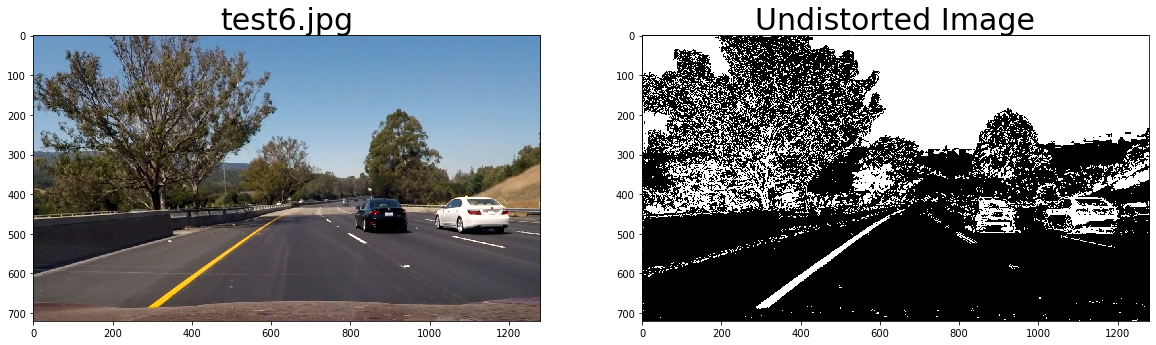

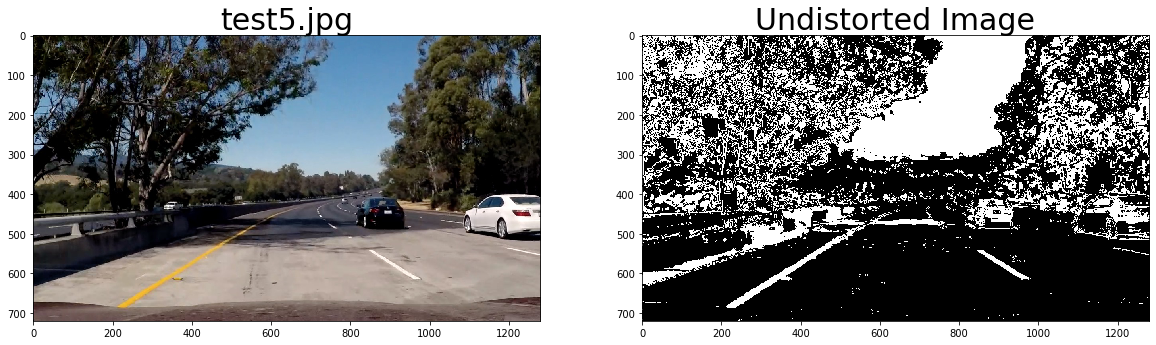

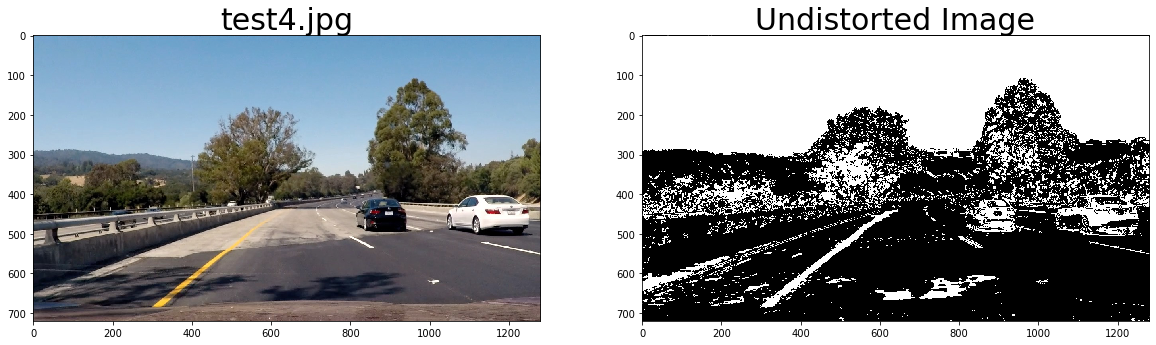

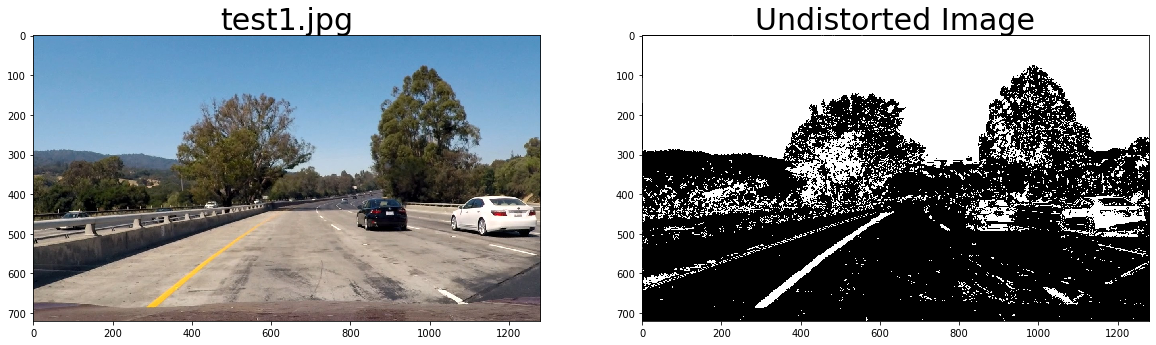

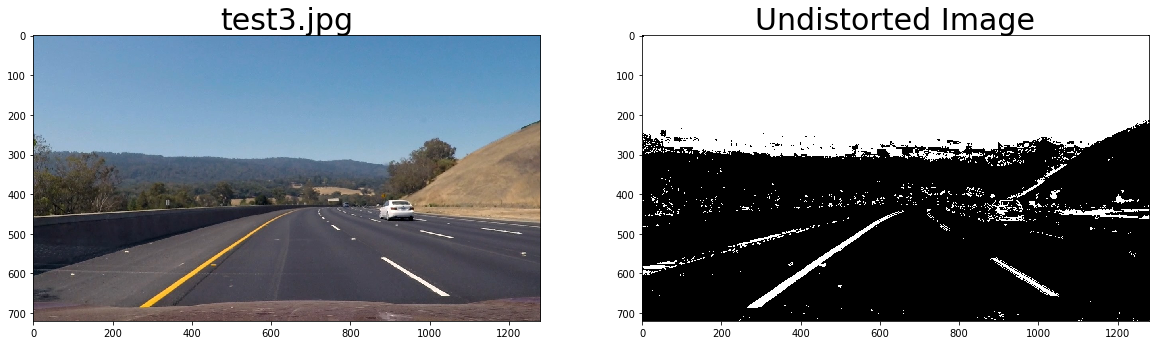

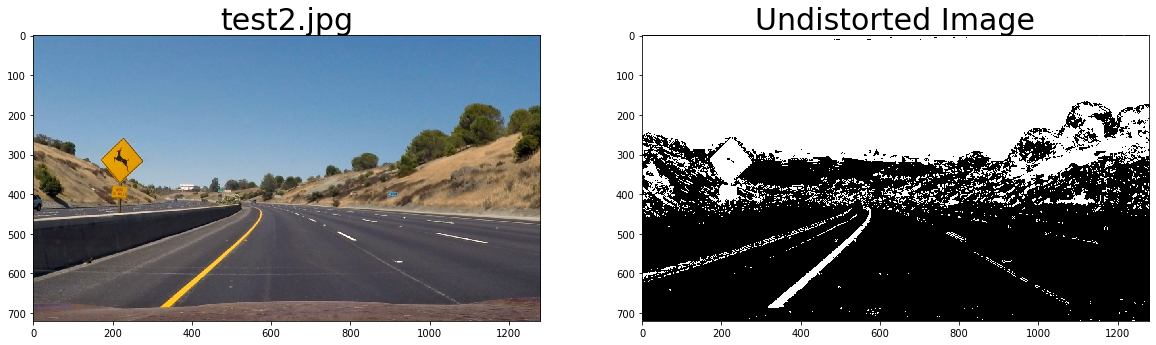

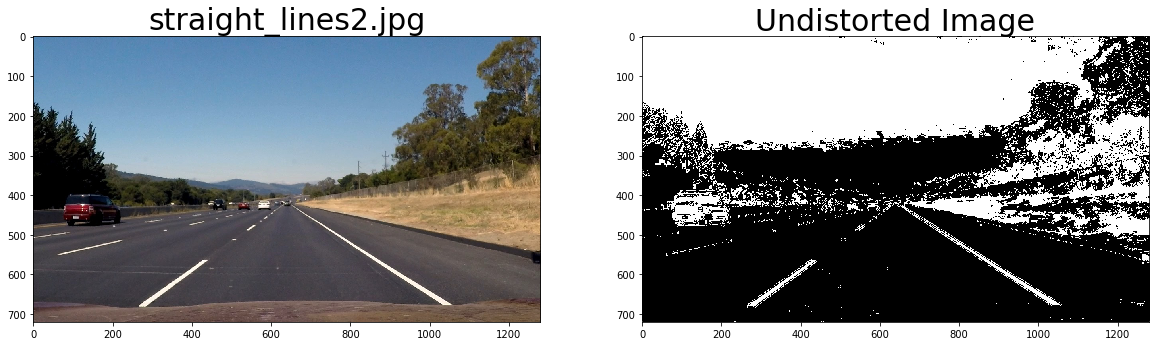

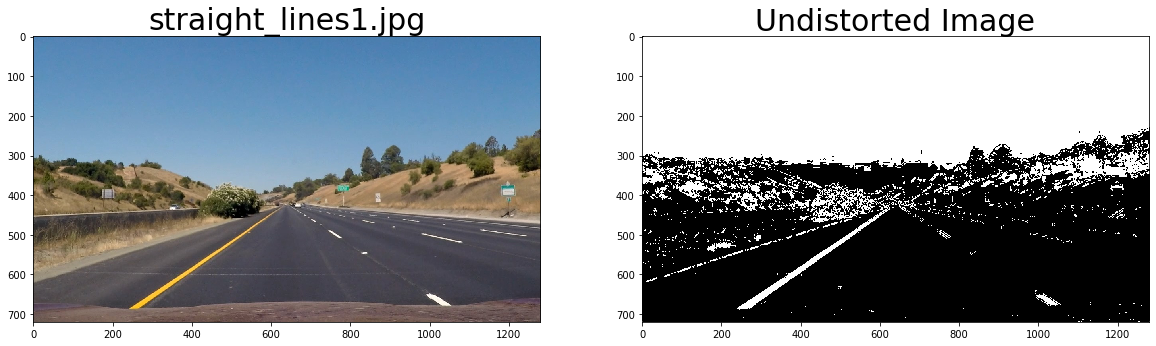

In [36]:
import os
images = os.listdir("test_images/")

lane = Lane()
lane.set_camera(camera)

for image_name in images:
    image = mpimg.imread("test_images/" + image_name)
    result = lane.pipeline(image)
    # print(result.shape)
    # undistorted = camera.undistort(image)
    
    # gray = Graph.toGrayscale(result)
    # mpimg.imsave("test_videos_output/" + image_name, result)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title(image_name, fontsize=30)
    ax2.imshow(result, cmap='gray')
    ax2.set_title('Undistorted Image', fontsize=30)

# Test pipeline on Movie - "project_video.mp4"

In [5]:
### Process movie

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane = Lane()
lane.set_camera(camera)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    binary = lane.pipeline(image)
    return Graph.to_3channel_binary(binary)

white_output = 'output_images/project_video_binary.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 2/1260 [00:00<01:57, 10.69it/s, now=None]

Moviepy - Building video output_images/project_video.mp4.
Moviepy - Writing video output_images/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video.mp4
CPU times: user 12min 40s, sys: 38.5 s, total: 13min 19s
Wall time: 3min 24s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Test pipeline on Movie - "challenge_video.mp4"

In [7]:
### Process movie

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane = Lane()
lane.set_camera(camera)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    binary = lane.pipeline(image)
    return Graph.to_3channel_binary(binary)

white_output = 'output_images/challenge_video_binary.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 2/485 [00:00<00:42, 11.45it/s, now=None]

Moviepy - Building video output_images/challenge_video_binary.mp4.
Moviepy - Writing video output_images/challenge_video_binary.mp4



Moviepy - Done !
Moviepy - video ready output_images/challenge_video_binary.mp4
CPU times: user 4min 49s, sys: 13.8 s, total: 5min 3s
Wall time: 1min 17s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Test pipeline on Movie - "harder_challenge_video.mp4"

In [9]:
### Process movie

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane = Lane()
lane.set_camera(camera)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    binary = lane.pipeline(image)
    return Graph.to_3channel_binary(binary)

white_output = 'output_images/harder_challenge_video_binary.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 2/1199 [00:00<01:44, 11.42it/s, now=None]

Moviepy - Building video output_images/harder_challenge_video_binary.mp4.
Moviepy - Writing video output_images/harder_challenge_video_binary.mp4



Moviepy - Done !
Moviepy - video ready output_images/harder_challenge_video_binary.mp4
CPU times: user 12min 28s, sys: 33.6 s, total: 13min 1s
Wall time: 3min 19s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))